In [1]:
import sys
import os

import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
import seaborn as sns

import scanpy as sc
import anndata as ad

import session_info
import warnings
from pyprojroot.here import here

from IPython.display import display
import scienceplots

warnings.filterwarnings("ignore")
sys.path.insert(1, str(here('bin')))

# Import functions
from customPythonFunctions import qc_gex_projectlibrary, get_HVG

plt.style.use(['nature'])
dpi_fig_save = 300
sc.set_figure_params(dpi=100, dpi_save=dpi_fig_save, vector_friendly=True)

pd.options.display.max_columns=300
pd.options.display.max_rows = 1000

### Setting parameters

In [2]:
overwriteFigures = True
overwriteData = True

In [3]:
cellGroup = 'T_CD4_NonNaive'
annotationDFpath = '/scratch_isilon/groups/singlecell/shared/projects/Inflammation-PBMCs-Atlas/02_cell_annotation/SCGT00_CentralizedDataset/02_fromCellLineages_to_CellTypes/Step2/Step2_clusterAnnotDF.pkl'
annotationColumns = 'annotation_step_2'
annColToInclude = None

In [4]:
workDir = os.getcwd()

# Preparing dataset

In [5]:
adataAll = ad.read_h5ad(here("01_data_processing/SCGT00_CentralizedDataset/results/2_SCGT00_MAIN_normalized.h5ad"))
adataAll

AnnData object with n_obs × n_vars = 855417 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors', 'log1p'
    layers: 'counts', 'log1

### Subsetting dataset

In [6]:
# Load the corresponding annotation
annotationDF = pd.read_pickle(here(annotationDFpath))
idxSelCells = annotationDF.index[annotationDF[annotationColumns] == cellGroup].tolist()
adata = adataAll[idxSelCells,:]
adata

View of AnnData object with n_obs × n_vars = 160017 × 37169
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors', 'log1p'
    layers: 'counts

In [7]:
adata.obs

,studyID,libraryID,sampleID,chemistry,technology,patientID,disease,timepoint_replicate,treatmentStatus,therapyResponse,sex,age,BMI,binned_age,diseaseStatus,smokingStatus,ethnicity,institute,diseaseGroup,batches,n_genes_by_counts,log1p_n_genes_by_counts,total_counts,log1p_total_counts,pct_counts_in_top_20_genes,total_counts_mt,log1p_total_counts_mt,pct_counts_mt,total_counts_ribo,log1p_total_counts_ribo,pct_counts_ribo,total_counts_hb,log1p_total_counts_hb,pct_counts_hb,total_counts_plt,log1p_total_counts_plt,pct_counts_plt,S_score,G2M_score,phase
cellID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
SCGT00_L051_I57.3P_T0_AAACCCAGTCAAAGAT,SCGT00,SCGT00_L051,SCGT00_I57.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I57,RA,0.0,ongoing,NR,female,47.000000,25.71,41-50,na,never-smoker,na,na,IMIDs,RA_Pool1Pool3,1409,7.251345,6185,8.730044,30.008084,155,5.049856,2.506063,2904,7.974189,46.952304,0,0.000000,0.00000,2,1.098612,0.032336,-0.013555,-0.029977,G1
SCGT00_L051_I52.3P_T0_AAACGAAAGGCTAACG,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,female,33.000000,21.37,31-40,na,never-smoker,na,na,IMIDs,RA_Pool1Pool3,969,6.877296,2408,7.786967,26.619601,225,5.420535,9.343854,582,6.368187,24.169435,0,0.000000,0.00000,1,0.693147,0.041528,-0.028606,0.043730,G2M
SCGT00_L051_I51.3P_T0_AAACGAAGTTCTAACG,SCGT00,SCGT00_L051,SCGT00_I51.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I51,RA,0.0,ongoing,R,female,42.000000,24.34,41-50,na,never-smoker,na,na,IMIDs,RA_Pool1Pool3,1144,7.043160,3811,8.245909,31.435319,178,5.187386,4.670690,1268,7.145984,33.272107,1,0.693147,0.02624,0,0.000000,0.000000,-0.034170,0.040275,G2M
SCGT00_L051_I52.3P_T0_AAACGAATCTACGCAA,SCGT00,SCGT00_L051,SCGT00_I52.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I52,RA,0.0,ongoing,NR,female,33.000000,21.37,31-40,na,never-smoker,na,na,IMIDs,RA_Pool1Pool3,1276,7.152269,5510,8.614501,29.927405,213,5.365976,3.865699,2410,7.787797,43.738657,0,0.000000,0.00000,3,1.386294,0.054446,0.000830,-0.045445,S
SCGT00_L051_I55.3P_T0_AAACGCTGTCTTTCTA,SCGT00,SCGT00_L051,SCGT00_I55.3P_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00_I55,RA,0.0,ongoing,R,female,58.000000,NaN,51-60,na,never-smoker,na,na,IMIDs,RA_Pool1Pool3,1314,7.181592,3790,8.240385,24.696570,169,5.135798,4.459103,1371,7.224025,36.174142,0,0.000000,0.00000,8,2.197225,0.211082,-0.025410,-0.046799,G1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SCGT00val_L003_I0361_T0_TTTGGAGAGGGAGAAT,SCGT00val,SCGT00val_L003,SCGT00val_I0361_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00val_I0361,RA,0.0,antiIL6R,R,female,37.000000,25.63,31-40,na,never-smoker,na,na,IMIDs,RA_Pool19Pool20,917,6.822197,3662,8.206038,28.590934,186,5.231109,5.079192,2086,7.643483,56.963408,0,0.000000,0.00000,0,0.000000,0.000000,-0.037043,0.006506,G2M
SCGT00val_L003_I0362_T0_TTTGGTTCACCCAATA,SCGT00val,SCGT00val_L003,SCGT00val_I0362_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00val_I0362,RA,0.0,antiIL6R,R,female,60.142368,NaN,61-70,na,na,na,na,IMIDs,RA_Pool19Pool20,1249,7.130899,4972,8.511779,33.266291,159,5.075174,3.197908,2337,7.757051,47.003218,0,0.000000,0.00000,0,0.000000,0.000000,0.083712,0.019856,S
SCGT00val_L003_I036010_T0_TTTGGTTCATGACGGA,SCGT00val,SCGT00val_L003,SCGT00val_I036010_T0,3_GEX_V3,3_GEX_V3_GenoHashed,SCGT00val_I036010,RA,0.0,antiIL6R,NR,female,61.000000,23.74,61-70,na,never-smoker,na,na,IMIDs,RA_Pool19Pool20,867,6.766192,3383,8.126814,32.101685,85,4.454347,2.512563,1802,7.497207,53.266332,1,0.693147,0.02956,1,0.693147,0.029560,-0.017519,-0.088592,G1


In [8]:
# Free some memory
del adataAll

### (Optional) Including annotation column

In [9]:
if annColToInclude is not None:
    adata.obs = adata.obs.merge(annotationDF[[annColToInclude]], left_index=True, right_index=True, how='left')
    adata.obs[annColToInclude].unique()

# Plotting Quality Control metrics

## Library quality control at CELL level

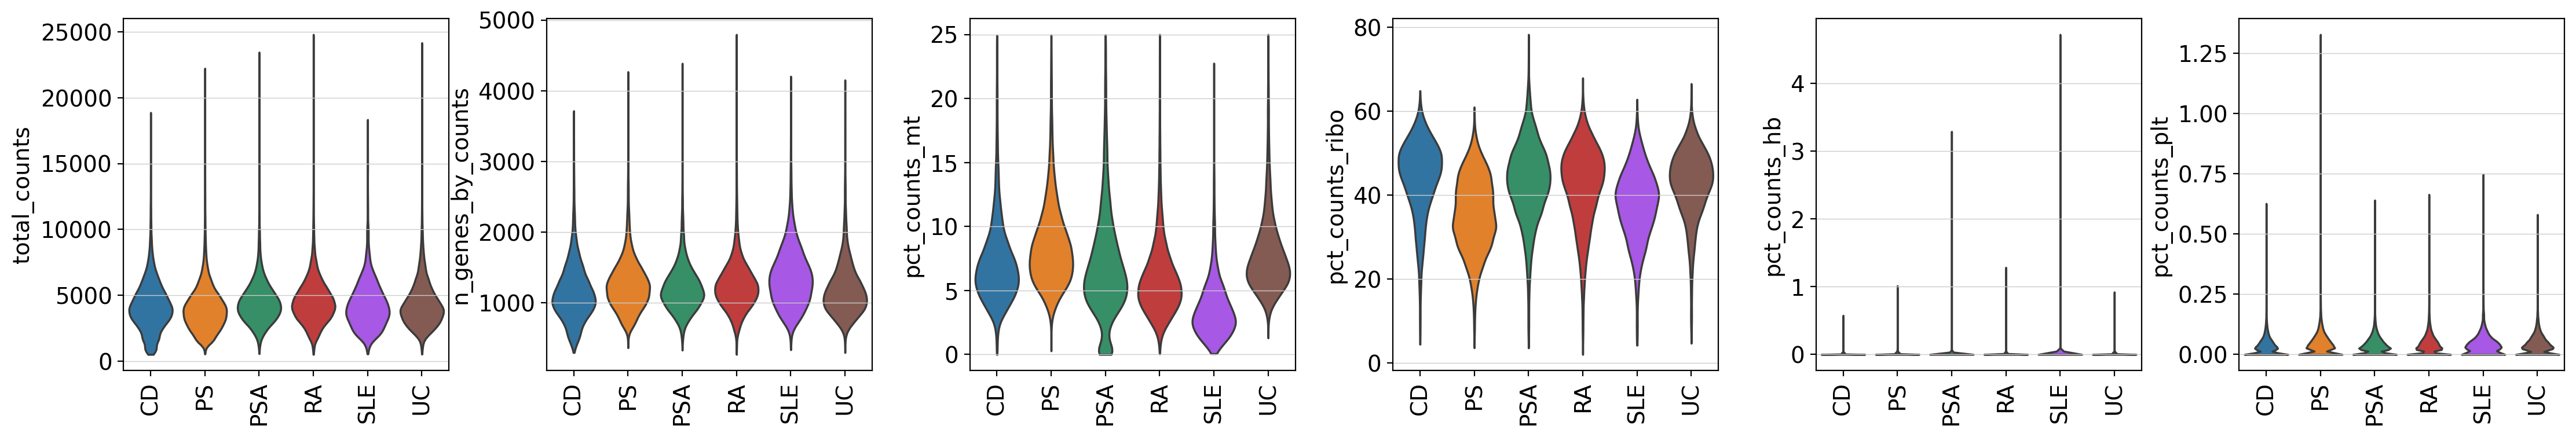

In [10]:
fig = sc.pl.violin(adata, 
                   [
                       'total_counts', 
                       'n_genes_by_counts', 
                       'pct_counts_mt',
                       'pct_counts_ribo',
                       'pct_counts_hb',
                       'pct_counts_plt'
                   ], 
                   groupby="disease",
                   stripplot=False, rotation=90, show=False)

if overwriteFigures:
    plt.savefig(here(workDir + '/results/figures/01_QC_totalCount_by_chemistry.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

In [11]:
# save the HUGO status information 
varDF = adata.var[['HUGO_status']]

**General QC statistics**

In [12]:
pd.set_option('display.max_rows', None)
qc_gex_df = qc_gex_projectlibrary(adata)
display(qc_gex_df)

pd.reset_option('display.max_rows')

,libraryID,chemistry,Number of cells,Median UMI counts,Median Genes,Median MT %,Median RB %,Median HB %
0,"(SCGT00_L000,)",[3_GEX_V3],4556,4563,1252,5.26,42.47,0.0
1,"(SCGT00_L002,)",[3_GEX_V3],5788,4666,1282,4.95,43.43,0.0
2,"(SCGT00_L004,)",[3_GEX_V3],404,6323,1666,6.00,41.57,0.0
3,"(SCGT00_L005,)",[3_GEX_V3],6903,3515,989,7.05,45.17,0.0
4,"(SCGT00_L007,)",[3_GEX_V3],2788,3942,1086,4.81,45.49,0.0
5,"(SCGT00_L008,)",[3_GEX_V3],1416,4191,1066,0.77,52.63,0.0
6,"(SCGT00_L009,)",[3_GEX_V3],6131,3854,1360,8.81,31.10,0.0
7,"(SCGT00_L011,)",[3_GEX_V3],2583,5016,1345,7.02,42.55,0.0
8,"(SCGT00_L012,)",[3_GEX_V3],4122,4500,1226,3.48,45.84,0.0
9,"(SCGT00_L015,)",[3_GEX_V3],4724,4231,1253,7.03,39.27,0.0


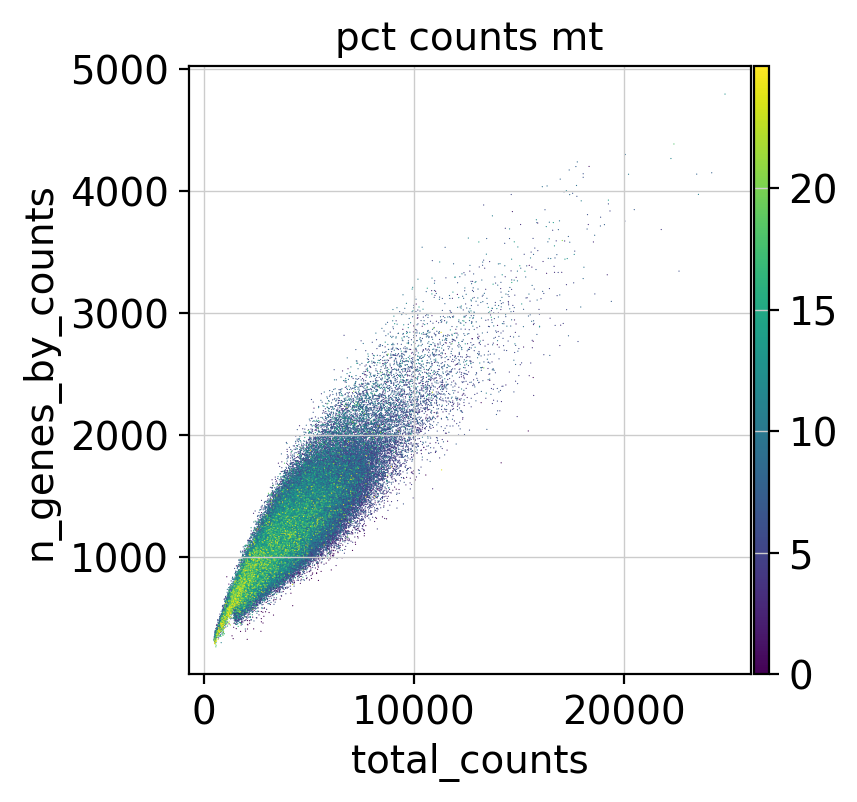

In [13]:
# Now, the whole dataset
fig = sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt",
                   show=False)

if overwriteFigures:
    plt.savefig(here(workDir + '/results/figures/01_QC_joinmetrics_allDatasets.pdf'), bbox_inches='tight', pad_inches=0, dpi=dpi_fig_save)

# HVG selection

**Excluding specific genes from HVG selection**

We have reasoned that T- and B- cell receptors genes, including VDJ joining and variable regions, are not useful to describe cell identities but rather to capture (generally) patient specific cell populations that are suffering clonal expansion within a specific pathological / inflammatory condition. Thus, we decided to exclude TCR and BCR genes as well as genes related with the Major Histocompatibility Complex (MHC) from the list of HVG selection that we will use to perform data integration. Additionally, we also decided to drop genes related to the mitochondrial and ribosomal organules since these might be largely biased due to different technical effects.

Although we are not really interested in studying neither to genes exclusive from to Red Blood Cells (such as hemoglobin) or Platelets (such as PPBP), we will keep them in order to be able to identify specific cell subsets we are not interested in (RBC or Platelets) and to better delineate the inflammation cell identity profile, such as these ones being very transcriptionally active. Then, once RBC and Platelets removed from our dataset, we will also exclude them.

In [14]:
# Retrieve MT and RB genes present in the dataset
MT_gene_idx = adata.var["symbol"].str.startswith("MT-")
print(f"{np.sum(MT_gene_idx)} mitochondrial genes")

RB_gene_idx = adata.var["symbol"].str.startswith(("RPS", "RPL"))
print(f"{np.sum(RB_gene_idx)} ribosomal genes")

# Retrieve TCR and BCR present in the dataset
TCR_gene_idx = adata.var["symbol"].str.contains("^TRA(J|V)|^TRB(J|V|D)")
print(f"{np.sum(TCR_gene_idx)} TCR genes")

BCR_gene_idx = adata.var["symbol"].str.contains("^IGH(J|V)")
print(f"{np.sum(BCR_gene_idx)} BCR genes")

MHC_gene_idx = adata.var["symbol"].str.contains("^HLA-")
print(f"{np.sum(MHC_gene_idx)} MHC genes")

# ### TO MODIFY & RUN when RBC and Platelets will be filtered out
HB_gene_idx = adata.var["symbol"].str.contains("^HB[^(P)]")
print(f"{np.sum(HB_gene_idx)} HB genes")

PLT_gene_idx = adata.var["symbol"].isin(["PPBP", "PDGF", "ANG1", "LAPTM4B", "WASF3", "TPM3", "PF4", "TAC1"])
print(f"{np.sum(PLT_gene_idx)} PLT genes")

exclude_gene_idx = (MT_gene_idx | RB_gene_idx | TCR_gene_idx | BCR_gene_idx | MHC_gene_idx )# | HB_gene_idx | PLT_gene_idx )

adata_forHVG = adata[:, ~exclude_gene_idx]
adata_forHVG

13 mitochondrial genes
113 ribosomal genes
198 TCR genes
159 BCR genes
21 MHC genes
12 HB genes
6 PLT genes


View of AnnData object with n_obs × n_vars = 160017 × 36665
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'disease_colors', 'log1p'
    layers: 'counts

In [15]:
try:
    sc.pp.highly_variable_genes(adata_forHVG, 
                                layer='log1p_10e4_counts', 
                                batch_key='libraryID', 
                                n_top_genes=None, 
                                min_disp=0.4, 
                                min_mean=0.015, 
                                max_mean=4, 
                                span=0.3, 
                                n_bins=20, 
                                flavor='seurat', 
                                inplace=True, 
                                check_values=True)

except Exception as e:
    print(f"An error occurred: {e}")
    print("Executing without library correction...")
    sc.pp.highly_variable_genes(adata_forHVG, 
                                layer='log1p_10e4_counts', 
                                batch_key=None, 
                                n_top_genes=None, 
                                min_disp=0.4, 
                                min_mean=0.015, 
                                max_mean=4, 
                                span=0.3, 
                                n_bins=20, 
                                flavor='seurat', 
                                inplace=True, 
                                check_values=True)

adata_forHVG.var.highly_variable.sum()

2130

In [16]:
print(f'The total number of selected HVG is {adata_forHVG.var.highly_variable.sum()}')

The total number of selected HVG is 2130


In [17]:
adata_HVG = adata_forHVG[:, adata_forHVG.var.highly_variable]
adata_HVG

View of AnnData object with n_obs × n_vars = 160017 × 2130
    obs: 'studyID', 'libraryID', 'sampleID', 'chemistry', 'technology', 'patientID', 'disease', 'timepoint_replicate', 'treatmentStatus', 'therapyResponse', 'sex', 'age', 'BMI', 'binned_age', 'diseaseStatus', 'smokingStatus', 'ethnicity', 'institute', 'diseaseGroup', 'batches', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_plt', 'log1p_total_counts_plt', 'pct_counts_plt', 'S_score', 'G2M_score', 'phase'
    var: 'hgnc_id', 'symbol', 'locus_group', 'HUGO_status', 'mt', 'ribo', 'hb', 'plt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'means', 'dispersions', 'dispersion

# Saving objects

In [18]:
# Save Anndata object (.h5ad file) 
if overwriteData:
    adata.write(here('{}/results/01_{}_normalized.h5ad'.format(workDir, cellGroup)), compression="gzip")

In [19]:
# Save Anndata object (.h5ad file) 
if overwriteData:
    adata_HVG.write(here('{}/results/01_{}_normalized_HVGsubset.h5ad'.format(workDir, cellGroup)), compression="gzip")

In [20]:
session_info.show()